In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw, DataStructs, rdFingerprintGenerator
from rdkit.ML.Cluster import Butina

In [2]:
data = pd.read_csv('data/EGFR_compounds_lipinski_1.csv', index_col=0)
data.head()

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hbd,n_hba,logp,passed
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,349.021459,1,3,5.2891,True
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,1,5,4.9333,True
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,1,5,3.5969,True
4,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,339.011957,2,4,4.0122,True
5,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,329.027607,2,5,3.5726,True


In [3]:
compounds = [(Chem.MolFromSmiles(sm), id) for sm, id in data[['smiles', 'molecule_chembl_id']].itertuples(index=False, name=None)]

In [4]:
compounds[:5]

[(<rdkit.Chem.rdchem.Mol at 0x1aed5df8740>, 'CHEMBL63786'),
 (<rdkit.Chem.rdchem.Mol at 0x1aed5df8970>, 'CHEMBL35820'),
 (<rdkit.Chem.rdchem.Mol at 0x1aed5df8ac0>, 'CHEMBL53711'),
 (<rdkit.Chem.rdchem.Mol at 0x1aed5df8b30>, 'CHEMBL66031'),
 (<rdkit.Chem.rdchem.Mol at 0x1aed5df8ba0>, 'CHEMBL53753')]

In [5]:
gen_finger = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [gen_finger.GetFingerprint(mol) for mol, _ in compounds]
fingerprints[:5]

In [6]:
def get_dissimilarity_matrix(fgs):
    dissimilarities = []
    for i in range(1, len(fgs)):
        similarities = DataStructs.BulkTanimotoSimilarity(fgs[i], fgs[:i])
        dissimilarities.extend([1 - sim for sim in similarities])
    return dissimilarities

In [7]:
get_dissimilarity_matrix(fingerprints)[:5]

[0.26996197718631176,
 0.26538461538461533,
 0.40866873065015474,
 0.09345794392523366,
 0.31182795698924726]

In [15]:
def get_clusters(fgs, cut_off=0.2):
    disim_matrix = get_dissimilarity_matrix(fgs)
    clusters = Butina.ClusterData(disim_matrix, len(fgs), cut_off, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

In [16]:
clusters = get_clusters(fingerprints, cut_off=0.3)

In [17]:
len(clusters)

975

In [18]:
print(sum([1 for c in clusters if len(c) == 1]))
for size in [5, 25, 100]:
    print(sum([1 for c in clusters if len(c) > size]))

478
205
36
6


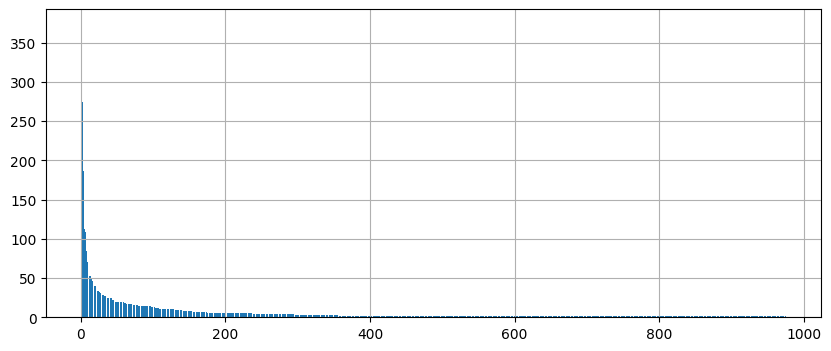

In [20]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(x=np.arange(1, len(clusters) + 1), height=[len(c) for c in clusters])
ax.grid()

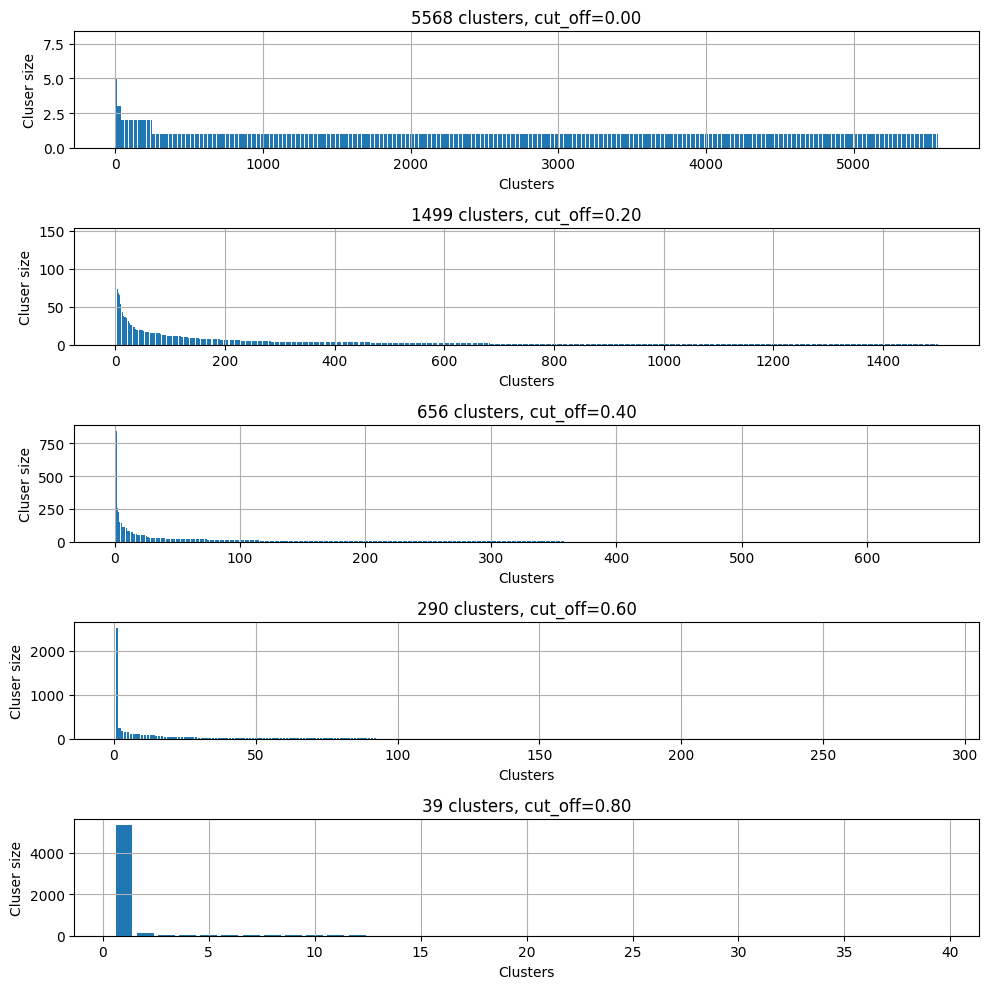

In [22]:
br = 0
fig, ax = plt.subplots(5, 1, figsize=(10, 10))
for cut_off in np.arange(0.0, 1.0, 0.2):
    cls = get_clusters(fingerprints, cut_off=cut_off)
    ax[br].bar(x=np.arange(1, len(cls) + 1), height=[len(c) for c in cls])
    ax[br].set_title(f'{len(cls)} clusters, cut_off={cut_off:.2f}')
    ax[br].set_xlabel('Clusters')
    ax[br].set_ylabel('Cluser size')
    ax[br].grid()
    br += 1
plt.tight_layout()

In [27]:
clusters = get_clusters(fingerprints, cut_off=0.2)

In [28]:
DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[0][1]])

0.8403361344537815

In [29]:
DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[1][0]])

0.5483870967741935

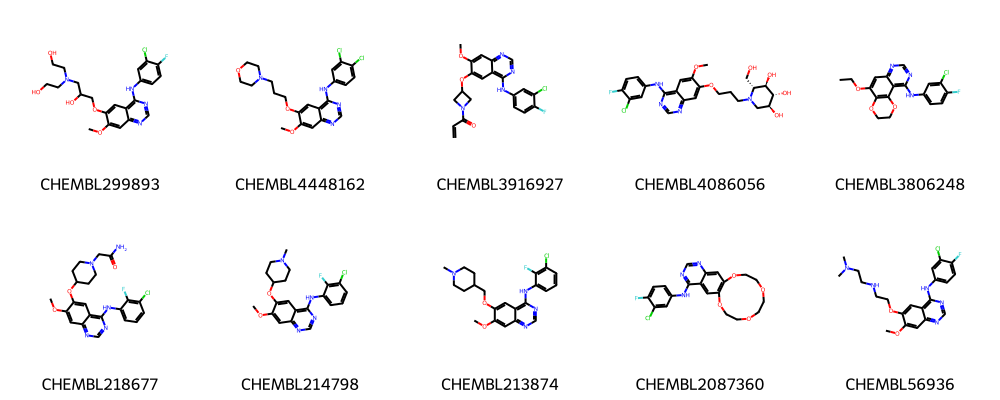

In [30]:
Draw.MolsToGridImage(
    [compounds[clusters[0][i]][0] for i in range(10)],
    legends=[compounds[clusters[0][i]][1] for i in range(10)],
    molsPerRow=5
)

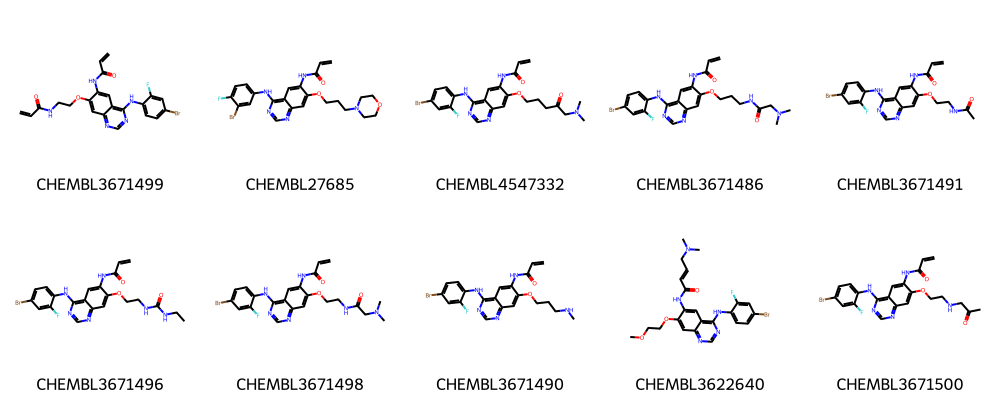

In [31]:
Draw.MolsToGridImage(
    [compounds[clusters[1][i]][0] for i in range(10)],
    legends=[compounds[clusters[1][i]][1] for i in range(10)],
    molsPerRow=5
)

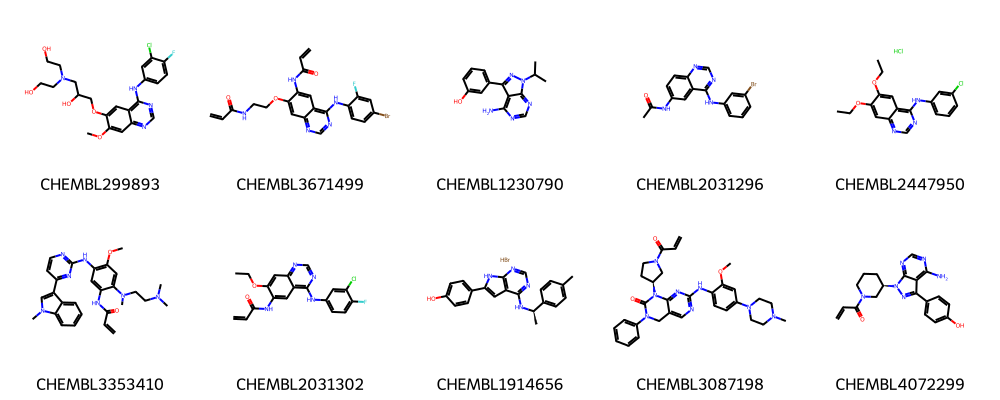

In [32]:
Draw.MolsToGridImage(
    [compounds[clusters[i][0]][0] for i in range(10)],
    legends=[compounds[clusters[i][0]][1] for i in range(10)],
    molsPerRow=5
)

In [33]:
cls_list = [-1] * len(data)
for i in range(len(clusters)):
    for comp_num in clusters[i]:
        cls_list[comp_num] = i
data['cluster'] = cls_list

In [34]:
data.head()

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hbd,n_hba,logp,passed,cluster
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,349.021459,1,3,5.2891,True,20
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,1,5,4.9333,True,4
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,1,5,3.5969,True,40
4,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,339.011957,2,4,4.0122,True,20
5,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,329.027607,2,5,3.5726,True,40


In [38]:
data[data['cluster'] == 200]

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hbd,n_hba,logp,passed,cluster
251,CHEMBL4562352,0.6,nM,CCOc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OC(=O)CSc1c...,9.221849,484.077217,1,8,5.6573,True,200
1096,CHEMBL4530170,5.0,nM,CCOc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OC(=O)CSc1n...,8.301030,489.078614,1,11,3.7858,True,200
1613,CHEMBL4572315,11.0,nM,CCOc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OC(=O)CSc1n...,7.958607,487.088116,1,9,4.9958,True,200
2253,CHEMBL4526992,27.0,nM,CCOc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OC(=O)CSc1n...,7.568636,473.072466,2,8,4.9854,True,200
2256,CHEMBL4558356,27.0,nM,CCOc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OC(=O)CSc1n...,7.568636,485.072466,1,9,5.0523,True,200
3318,CHEMBL4521214,70.0,nM,CCOc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OC(=O)CSc1c...,7.154902,484.077217,1,8,5.6573,True,200


In [40]:
[compounds[clusters[200][i]][1] for i in range(len(clusters[200]))]

['CHEMBL4558356',
 'CHEMBL4562352',
 'CHEMBL4530170',
 'CHEMBL4572315',
 'CHEMBL4526992',
 'CHEMBL4521214']

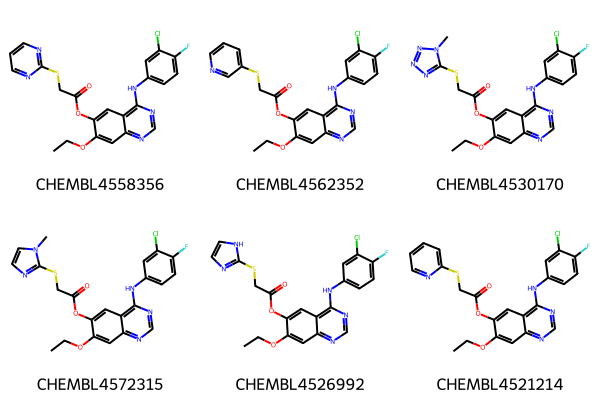

In [41]:
Draw.MolsToGridImage(
    [compounds[clusters[200][i]][0] for i in range(len(clusters[200]))],
    legends=[compounds[clusters[200][i]][1] for i in range(len(clusters[200]))],
    molsPerRow=len(clusters[200]) // 2
)